In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter

In [3]:
user = os.getenv('API_USERNAME') 
password = os.getenv('API_PASSWORD')
root = r"http://10.0.0.138/api/v1/"
owi = API(api_root=root, username=user, password=password)

In [5]:
owi.groups

,project,locations,datagroups
id,,,
1,prj_smartbridge,"[mo01, opzuid]","[acceleration, fiber, mpe]"
2,nobelwind,"[bbg10, bbk05, bbg08]","[acceleration, bolt, corrosion, fatigue, incli..."
3,parkwind,[bbc01],"[acceleration, mpe, scada]"


In [8]:
owi.groups.iloc[2]

project                         parkwind
locations                        [bbc01]
datagroups    [acceleration, mpe, scada]
Name: 3, dtype: object

In [9]:
start  = datetime.datetime(2012,1,1,tzinfo=utc)
stop  = datetime.datetime(2023,7,19,tzinfo=utc)

location = 'bbc01'
name_location = 'BB_C01'

dsg = DatasetGetter(start, stop, location)
dsg.get_longterm_data()

In [10]:
home_folder = "../../"
# Data Paths
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = home_folder + "data/bb/raw/" + data_file_name + ".parquet"
dsg.save_data(data_path)

In [11]:
mvbc_username = os.getenv('MEETNET_USERNAME') # Replace with your usernam
mvbc_password = os.getenv('MEETNET_PASSWORD') # Replace with your password
creds = Credentials(username=mvbc_username, password=mvbc_password)
b=Base(creds)
b.ping()

c = Catalog(credentials=creds)
df_unfiltered = c.data_points()

In [12]:
weather_station = 'Wandelaar'
weather_station_data = \
    dg.get_data_by_weatherstation(
        weather_station,
        start,
        stop,
        creds,
        df_unfiltered
    )
weather_station_data = weather_station_data.resample('10T', axis=0).interpolate(method='linear', axis=0, limit=12)

In [13]:
# Make a column that combines sea water temperature measurements of Pile and Buoy
Sea_water_temp = pd.concat([
    weather_station_data['mvbc_WandelaarMeasuringpile_Sea_water_temperature'].dropna(),
    weather_station_data['mvbc_WandelaarBuoy_Sea_water_temperature'].dropna()
    ], axis=0)
Sea_water_temp = Sea_water_temp.resample('10T', axis=0).interpolate(method='linear', axis=0, limit=12)
weather_station_data['mvbc_Wandelaar_Sea_water_temperature_'] = Sea_water_temp

In [14]:
weather_data_path = "../../data/nw2/Wandelaar_data_longterm.parquet"
weather_station_data.to_parquet(weather_data_path, compression='gzip')

In [15]:
weather_station = 'Westhinder'
Westhinder_data = \
    dg.get_data_by_weatherstation(
        weather_station,
        start,
        stop,
        creds,
        df_unfiltered
    )
Westhinder_data = Westhinder_data.resample('10T', axis=0).interpolate(method='linear', axis=0, limit=12)

In [16]:
Westhinder_data_path = "../../data/nw2/Westhinder_data_longterm.parquet"
Westhinder_data.to_parquet(Westhinder_data_path, compression='gzip')

In [17]:
Westhinder_data.isna().sum()

mvbc_WesthinderBuoy_10%_highest_waves                                     22022
mvbc_WesthinderBuoy_Wave_height                                           22022
mvbc_WesthinderBuoy_Average_wave_period                                   22022
mvbc_WesthinderBuoy_Height_waves_with_period_>_10_s                       22044
mvbc_WesthinderBuoy_High_frequent_wave_direction                          23722
mvbc_WesthinderBuoy_Low_frequent_wave_direction                           23726
mvbc_WesthinderMeasuringpile_Sea_water_temperature                        76766
mvbc_WesthinderBuoy_Sea_water_temperature                                 84796
mvbc_WesthinderMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)     28884
mvbc_WesthinderMeasuringpile_Average_wind_direction                       29511
mvbc_WesthinderMeasuringpile_Average_wind_speed_(at_10_m_height)          30021
mvbc_WesthinderMeasuringpile_Tide_TAW                                     27726
mvbc_WesthinderMeasuringpile_Air_pressur

In [18]:
weather_station = 'Thorntonbank'
Thorntonbank_data = \
    dg.get_data_by_weatherstation(
        weather_station,
        start,
        stop,
        creds,
        df_unfiltered
    )
Thorntonbank_data = Thorntonbank_data.resample('10T', axis=0).interpolate(method='linear', axis=0, limit=12)

In [19]:
Thorntonbank_data_path = "../../data/nw2/Thorntonbank_data_longterm.parquet"
Thorntonbank_data.to_parquet(Thorntonbank_data_path, compression='gzip')

In [20]:
Thorntonbank_data.isna().sum()

mvbc_ThorntonbankSouthBuoy_10%_highest_waves                    528
mvbc_ThorntonbankSouthBuoy_Wave_height                          528
mvbc_ThorntonbankSouthBuoy_Average_wave_period                  528
mvbc_ThorntonbankSouthBuoy_Height_waves_with_period_>_10_s      528
mvbc_ThorntonbankSouthBuoy_High_frequent_wave_direction       24891
mvbc_ThorntonbankSouthBuoy_Low_frequent_wave_direction        24891
mvbc_ThorntonbankSouthBuoy_Sea_water_temperature                536
dtype: int64

In [21]:
Westhinder_data.columns

Index(['mvbc_WesthinderBuoy_10%_highest_waves',
       'mvbc_WesthinderBuoy_Wave_height',
       'mvbc_WesthinderBuoy_Average_wave_period',
       'mvbc_WesthinderBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WesthinderBuoy_High_frequent_wave_direction',
       'mvbc_WesthinderBuoy_Low_frequent_wave_direction',
       'mvbc_WesthinderMeasuringpile_Sea_water_temperature',
       'mvbc_WesthinderBuoy_Sea_water_temperature',
       'mvbc_WesthinderMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WesthinderMeasuringpile_Average_wind_direction',
       'mvbc_WesthinderMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WesthinderMeasuringpile_Tide_TAW',
       'mvbc_WesthinderMeasuringpile_Air_pressure',
       'mvbc_WesthinderMeasuringpile_Air_temperature',
       'mvbc_WesthinderMeasuringpile_Relative_humidity'],
      dtype='object')

In [22]:
weather_station_data.columns

Index(['mvbc_WandelaarBuoy_10%_highest_waves',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s',
       'mvbc_WandelaarMeasuringpile_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Average_wind_direction',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Flow_direction_cell_3',
       'mvbc_WandelaarBuoy_1%_wave_height',
       'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)',
       'mvbc_WandelaarMeasuringpile_Air_temperature',
       'mvbc_WandelaarBuoy_Sea_water_temperature',
       'mvbc_WandelaarMeasuringpile_Relative_humidity',
       'mvbc_Wandelaar_Sea_water_temperature_'],
      dtype='object')

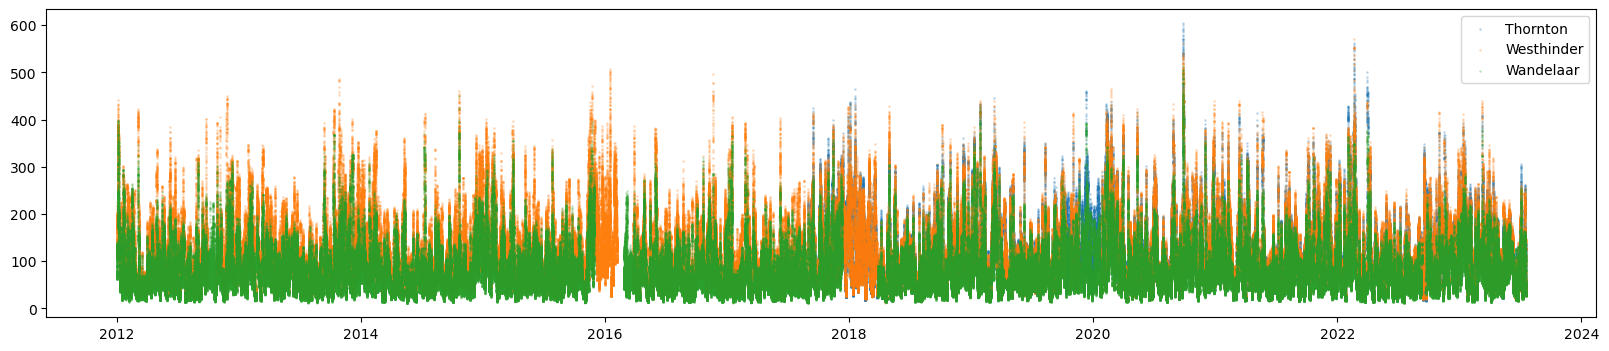

In [23]:
plt.figure(figsize=(20,4))
plt.scatter(Thorntonbank_data.index, Thorntonbank_data['mvbc_ThorntonbankSouthBuoy_Wave_height'], label='Thornton', s=1, alpha=0.2)
plt.scatter(Westhinder_data.index, Westhinder_data['mvbc_WesthinderBuoy_Wave_height'], label='Westhinder', s=1, alpha=0.2)
plt.scatter(weather_station_data.index, weather_station_data['mvbc_WandelaarBuoy_Wave_height'], label='Wandelaar', s=1, alpha=0.2)
plt.legend()
plt.show()

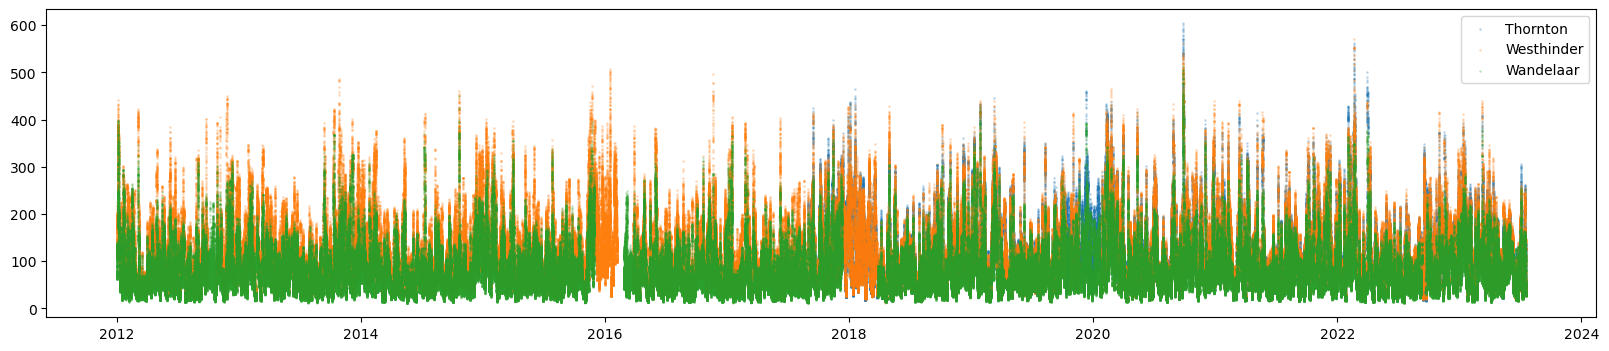

In [24]:
plt.figure(figsize=(20,4))
plt.scatter(Thorntonbank_data.index, Thorntonbank_data['mvbc_ThorntonbankSouthBuoy_Wave_height'], label='Thornton', s=1, alpha=0.2)
plt.scatter(Westhinder_data.index, Westhinder_data['mvbc_WesthinderBuoy_Wave_height'], label='Westhinder', s=1, alpha=0.2)
plt.scatter(weather_station_data.index, weather_station_data['mvbc_WandelaarBuoy_Wave_height'], label='Wandelaar', s=1, alpha=0.2)
plt.legend()
plt.show()

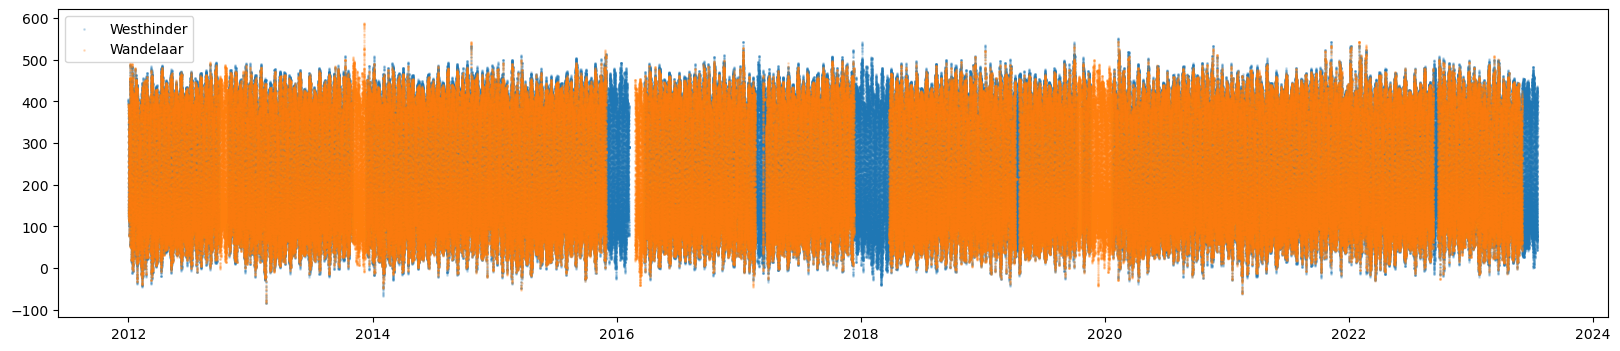

In [25]:
plt.figure(figsize=(20,4))
plt.scatter(Westhinder_data.index, Westhinder_data['mvbc_WesthinderMeasuringpile_Tide_TAW'], label='Westhinder', s=1, alpha=0.2)
plt.scatter(weather_station_data.index, weather_station_data['mvbc_WandelaarMeasuringpile_Tide_TAW'], label='Wandelaar', s=1, alpha=0.2)
plt.legend()
plt.show()

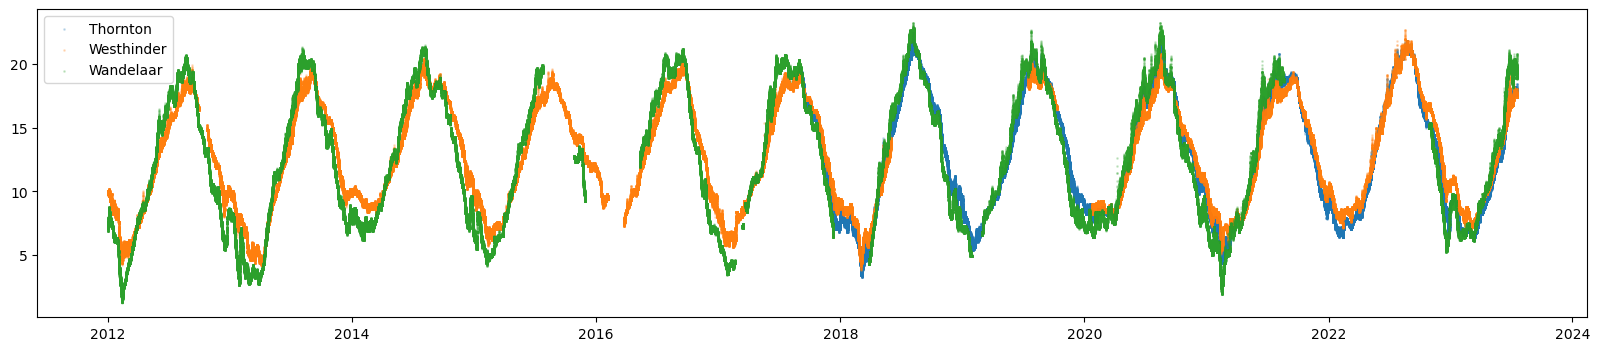

In [29]:
plt.figure(figsize=(20,4))
plt.scatter(Thorntonbank_data.index, Thorntonbank_data['mvbc_ThorntonbankSouthBuoy_Sea_water_temperature'], label='Thornton', s=1, alpha=0.2)
plt.scatter(Westhinder_data.index, Westhinder_data['mvbc_WesthinderBuoy_Sea_water_temperature'], label='Westhinder', s=1, alpha=0.2)
plt.scatter(weather_station_data.index, weather_station_data['mvbc_Wandelaar_Sea_water_temperature_'], label='Wandelaar', s=1, alpha=0.2)
plt.legend()
plt.show()

In [40]:
col_names = []
for col in weather_station_data.columns:
    var_name = col.split('_')[2:]
    var_name = '_'.join(var_name)
    col_names.append(var_name)
    print(var_name)
columns_impute = col_names[:-1]
columns_impute

10%_highest_waves
Wave_height
Average_wave_period
Height_waves_with_period_>_10_s
Sea_water_temperature
Max_3-seconds_wind_gust_(at_10_m_height)
Average_wind_direction
Tide_TAW
Air_pressure
Flow_direction_cell_3
1%_wave_height
Average_wind_speed_(at_10_m_height)
Air_temperature
Sea_water_temperature
Relative_humidity
Sea_water_temperature_


['10%_highest_waves',
 'Wave_height',
 'Average_wave_period',
 'Height_waves_with_period_>_10_s',
 'Sea_water_temperature',
 'Max_3-seconds_wind_gust_(at_10_m_height)',
 'Average_wind_direction',
 'Tide_TAW',
 'Air_pressure',
 'Flow_direction_cell_3',
 '1%_wave_height',
 'Average_wind_speed_(at_10_m_height)',
 'Air_temperature',
 'Sea_water_temperature',
 'Relative_humidity']

In [52]:
weather_data = weather_station_data.copy()
weatherstations_data = {'Westhinder': Westhinder_data, 'Thorntonbank': Thorntonbank_data}

weatherstations = ['Westhinder', 'Thorntonbank']
#columns_impute = ['Sea_water_temperature', 'Tide_TAW', 'Wave_height', 'Average_wave_period', 'Air_pressure', 'Air_temperature']
for column in columns_impute:
    new_data = weather_data.filter(regex=column)
    if len(new_data.columns) > 1:
        #select columns with less nans
        kept_column = weather_data.filter(regex=column).isna().sum().sort_values().index[0]
        new_data = weather_data[kept_column]
    if not new_data.empty:
        print('new data for column: ', column, new_data)
        weather_data[column] = new_data
    for weatherstation in weatherstations:
        print(weatherstation, column)
        try:
            replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]
            if len(replacing_data.columns) > 1:
                #select columns with less nans
                kept_column = replacing_data.isna().sum().sort_values().index[0]
            elif len(replacing_data.columns) == 1:
                kept_column = replacing_data.columns[0]
                print(kept_column)
            else:
                print('no data for weatherstation: ', weatherstation, ' and column: ', column)
                continue
            replacing_data = weatherstations_data[weatherstation][kept_column]
            weather_data.loc[weather_data[column].isna(), column] = replacing_data[weather_data[column].isna()]
            print('replaced')
        except:
            print('no data for weatherstation: ', weatherstation, ' and column: ', column)


new data for column:  10%_highest_waves                            mvbc_WandelaarBuoy_10%_highest_waves
Timestamp                                                      
2012-01-01 00:00:00+00:00                            117.000000
2012-01-01 00:10:00+00:00                            133.333333
2012-01-01 00:20:00+00:00                            149.666667
2012-01-01 00:30:00+00:00                            166.000000
2012-01-01 00:40:00+00:00                            168.666667
...                                                         ...
2023-07-18 23:20:00+00:00                             37.333333
2023-07-18 23:30:00+00:00                             36.000000
2023-07-18 23:40:00+00:00                             35.666667
2023-07-18 23:50:00+00:00                             35.333333
2023-07-19 00:00:00+00:00                             35.000000

[607249 rows x 1 columns]
Westhinder 10%_highest_waves
mvbc_WesthinderBuoy_10%_highest_waves
replaced
Thorntonbank 10%_highest_

C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


new data for column:  Wave_height                            mvbc_WandelaarBuoy_Wave_height
Timestamp                                                
2012-01-01 00:00:00+00:00                       94.000000
2012-01-01 00:10:00+00:00                      104.000000
2012-01-01 00:20:00+00:00                      114.000000
2012-01-01 00:30:00+00:00                      124.000000
2012-01-01 00:40:00+00:00                      127.000000
...                                                   ...
2023-07-18 23:20:00+00:00                       29.333333
2023-07-18 23:30:00+00:00                       28.000000
2023-07-18 23:40:00+00:00                       27.666667
2023-07-18 23:50:00+00:00                       27.333333
2023-07-19 00:00:00+00:00                       27.000000

[607249 rows x 1 columns]
Westhinder Wave_height
mvbc_WesthinderBuoy_Wave_height
replaced
Thorntonbank Wave_height
mvbc_ThorntonbankSouthBuoy_Wave_height
replaced
new data for column:  Average_wave_period       

C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


Westhinder Average_wave_period
mvbc_WesthinderBuoy_Average_wave_period
replaced
Thorntonbank Average_wave_period
mvbc_ThorntonbankSouthBuoy_Average_wave_period
replaced
new data for column:  Height_waves_with_period_>_10_s                            mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s
Timestamp                                                                    
2012-01-01 00:00:00+00:00                                          13.000000 
2012-01-01 00:10:00+00:00                                          13.333333 
2012-01-01 00:20:00+00:00                                          13.666667 
2012-01-01 00:30:00+00:00                                          14.000000 
2012-01-01 00:40:00+00:00                                          14.666667 
...                                                                      ... 
2023-07-18 23:20:00+00:00                                           1.000000 
2023-07-18 23:30:00+00:00                                           1.00000

C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


Westhinder Height_waves_with_period_>_10_s
mvbc_WesthinderBuoy_Height_waves_with_period_>_10_s
replaced
Thorntonbank Height_waves_with_period_>_10_s
mvbc_ThorntonbankSouthBuoy_Height_waves_with_period_>_10_s
replaced


C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


new data for column:  Sea_water_temperature Timestamp
2012-01-01 00:00:00+00:00     6.900000
2012-01-01 00:10:00+00:00     6.900000
2012-01-01 00:20:00+00:00     6.900000
2012-01-01 00:30:00+00:00     6.900000
2012-01-01 00:40:00+00:00     6.900000
                               ...    
2023-07-18 23:20:00+00:00    19.666667
2023-07-18 23:30:00+00:00    19.700000
2023-07-18 23:40:00+00:00    19.633333
2023-07-18 23:50:00+00:00    19.566667
2023-07-19 00:00:00+00:00    19.500000
Freq: 10T, Name: mvbc_Wandelaar_Sea_water_temperature_, Length: 607249, dtype: float64
Westhinder Sea_water_temperature
replaced
Thorntonbank Sea_water_temperature
mvbc_ThorntonbankSouthBuoy_Sea_water_temperature
replaced


C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


Westhinder Max_3-seconds_wind_gust_(at_10_m_height)
no data for weatherstation:  Westhinder  and column:  Max_3-seconds_wind_gust_(at_10_m_height)
Thorntonbank Max_3-seconds_wind_gust_(at_10_m_height)
no data for weatherstation:  Thorntonbank  and column:  Max_3-seconds_wind_gust_(at_10_m_height)
new data for column:  Average_wind_direction                            mvbc_WandelaarMeasuringpile_Average_wind_direction
Timestamp                                                                    
2012-01-01 00:00:00+00:00                                         222.000000 
2012-01-01 00:10:00+00:00                                         223.000000 
2012-01-01 00:20:00+00:00                                         224.000000 
2012-01-01 00:30:00+00:00                                         225.000000 
2012-01-01 00:40:00+00:00                                         224.000000 
...                                                                      ... 
2023-07-18 23:20:00+00:00        

C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]
C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


no data for weatherstation:  Thorntonbank  and column:  Tide_TAW
new data for column:  Air_pressure                            mvbc_WandelaarMeasuringpile_Air_pressure
Timestamp                                                          
2012-01-01 00:00:00+00:00                               1008.600000
2012-01-01 00:10:00+00:00                               1008.500000
2012-01-01 00:20:00+00:00                               1008.400000
2012-01-01 00:30:00+00:00                               1008.300000
2012-01-01 00:40:00+00:00                               1008.266667
...                                                             ...
2023-07-18 23:20:00+00:00                               1013.400000
2023-07-18 23:30:00+00:00                               1013.400000
2023-07-18 23:40:00+00:00                               1013.333333
2023-07-18 23:50:00+00:00                               1013.266667
2023-07-19 00:00:00+00:00                               1013.200000

[607249 rows x 

C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]
C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


new data for column:  Flow_direction_cell_3                            mvbc_WandelaarMeasuringpile_Flow_direction_cell_3
Timestamp                                                                   
2012-01-01 00:00:00+00:00                                         261.470000
2012-01-01 00:10:00+00:00                                         259.943333
2012-01-01 00:20:00+00:00                                         258.416667
2012-01-01 00:30:00+00:00                                         256.890000
2012-01-01 00:40:00+00:00                                         256.303333
...                                                                      ...
2023-07-18 23:20:00+00:00                                                NaN
2023-07-18 23:30:00+00:00                                                NaN
2023-07-18 23:40:00+00:00                                                NaN
2023-07-18 23:50:00+00:00                                                NaN
2023-07-19 00:00:00+00:00       

C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


Westhinder Average_wind_speed_(at_10_m_height)
no data for weatherstation:  Westhinder  and column:  Average_wind_speed_(at_10_m_height)
Thorntonbank Average_wind_speed_(at_10_m_height)
no data for weatherstation:  Thorntonbank  and column:  Average_wind_speed_(at_10_m_height)
new data for column:  Air_temperature                            mvbc_WandelaarMeasuringpile_Air_temperature
Timestamp                                                             
2012-01-01 00:00:00+00:00                                          NaN
2012-01-01 00:10:00+00:00                                          NaN
2012-01-01 00:20:00+00:00                                          NaN
2012-01-01 00:30:00+00:00                                          NaN
2012-01-01 00:40:00+00:00                                          NaN
...                                                                ...
2023-07-18 23:20:00+00:00                                    19.000000
2023-07-18 23:30:00+00:00                    

C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


new data for column:  Sea_water_temperature Timestamp
2012-01-01 00:00:00+00:00     6.900000
2012-01-01 00:10:00+00:00     6.900000
2012-01-01 00:20:00+00:00     6.900000
2012-01-01 00:30:00+00:00     6.900000
2012-01-01 00:40:00+00:00     6.900000
                               ...    
2023-07-18 23:20:00+00:00    19.666667
2023-07-18 23:30:00+00:00    19.700000
2023-07-18 23:40:00+00:00    19.633333
2023-07-18 23:50:00+00:00    19.566667
2023-07-19 00:00:00+00:00    19.500000
Freq: 10T, Name: Sea_water_temperature, Length: 607249, dtype: float64
Westhinder Sea_water_temperature
replaced
Thorntonbank Sea_water_temperature
mvbc_ThorntonbankSouthBuoy_Sea_water_temperature
replaced


C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


new data for column:  Relative_humidity                            mvbc_WandelaarMeasuringpile_Relative_humidity
Timestamp                                                               
2012-01-01 00:00:00+00:00                                            NaN
2012-01-01 00:10:00+00:00                                            NaN
2012-01-01 00:20:00+00:00                                            NaN
2012-01-01 00:30:00+00:00                                            NaN
2012-01-01 00:40:00+00:00                                            NaN
...                                                                  ...
2023-07-18 23:20:00+00:00                                      67.666667
2023-07-18 23:30:00+00:00                                      68.000000
2023-07-18 23:40:00+00:00                                      67.333333
2023-07-18 23:50:00+00:00                                      66.666667
2023-07-19 00:00:00+00:00                                      66.000000

[607249 ro

C:\Users\Max\AppData\Local\Temp\ipykernel_28864\3668328906.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  replacing_data = weatherstations_data[weatherstation].filter(regex=column)[weather_data[column].isna()]


In [54]:
1-weather_data.isna().sum()/len(weather_data)

mvbc_WandelaarBuoy_10%_highest_waves                                    0.948929
mvbc_WandelaarBuoy_Wave_height                                          0.948929
mvbc_WandelaarBuoy_Average_wave_period                                  0.947616
mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s                      0.929936
mvbc_WandelaarMeasuringpile_Sea_water_temperature                       0.519196
mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)    0.797353
mvbc_WandelaarMeasuringpile_Average_wind_direction                      0.932701
mvbc_WandelaarMeasuringpile_Tide_TAW                                    0.930901
mvbc_WandelaarMeasuringpile_Air_pressure                                0.918124
mvbc_WandelaarMeasuringpile_Flow_direction_cell_3                       0.430668
mvbc_WandelaarBuoy_1%_wave_height                                       0.494140
mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)         0.797286
mvbc_WandelaarMeasuringpile_

In [34]:
weather_data_path = "../../data/nw2/mvbc_data_longterm.parquet"

weather_data.to_parquet(weather_data_path, compression='gzip')